<a href="https://colab.research.google.com/github/carsofferrei/edit-g2-final-project/blob/streaming_measures_calculations/Streaming_Final_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Import Libraries**

In [24]:
import os
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, LongType
from pyspark.sql.functions import col, count, sum, lit, window, first, sqrt, pow, last, when
from pyspark.sql.window import Window
import time

# **2. Set Up Environment**

In [25]:
# Install required packages and dependencies
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!pip install pyspark==3.5.0 -q
!pip install gcsfs -q
!wget https://repo1.maven.org/maven2/com/google/cloud/bigdataoss/gcs-connector/hadoop3-2.2.7/gcs-connector-hadoop3-2.2.7-shaded.jar -P /usr/local/lib/
!gcloud auth application-default login

# Remove all files in the /content/output directory to clean up before processing
!rm -rf /content/output/*


--2025-01-24 19:55:28--  https://repo1.maven.org/maven2/com/google/cloud/bigdataoss/gcs-connector/hadoop3-2.2.7/gcs-connector-hadoop3-2.2.7-shaded.jar
Resolving repo1.maven.org (repo1.maven.org)... 199.232.192.209, 199.232.196.209, 2a04:4e42:4c::209, ...
Connecting to repo1.maven.org (repo1.maven.org)|199.232.192.209|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33831577 (32M) [application/java-archive]
Saving to: ‘/usr/local/lib/gcs-connector-hadoop3-2.2.7-shaded.jar.1’

gcs-connector-hadoo 100%[===================>]  32.26M  --.-KB/s    in 0.1s    

2025-01-24 19:55:29 (245 MB/s) - ‘/usr/local/lib/gcs-connector-hadoop3-2.2.7-shaded.jar.1’ saved [33831577/33831577]


The environment variable [GOOGLE_APPLICATION_CREDENTIALS] is set to:
  [/content/.config/application_default_credentials.json]
Credentials will still be generated to the default location:
  [/content/.config/application_default_credentials.json]
To use these credentials, unset this environment 

# **3. Create Spark Session and Configure GCS**

In [26]:
# Create the Spark session with the GCS connector
spark = SparkSession.builder \
    .appName("GCSReadVehicles") \
    .config("spark.jars", "/usr/local/lib/gcs-connector-hadoop3-2.2.7-shaded.jar") \
    .config("spark.hadoop.fs.gs.impl", "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFileSystem") \
    .getOrCreate()

# Path to the credentials file generated by gcloud
credential_path = "/content/.config/application_default_credentials.json"

# Set up the environment for credentials
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = credential_path

# Configure PySpark to access GCS
spark._jsc.hadoopConfiguration().set("fs.gs.impl", "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFileSystem")
spark._jsc.hadoopConfiguration().set("fs.AbstractFileSystem.gs.impl", "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFS")
spark._jsc.hadoopConfiguration().set("fs.gs.auth.service.account.enable", "true")
spark._jsc.hadoopConfiguration().set("google.cloud.auth.service.account.json.keyfile", credential_path)


# **4. Define Input Path and Schema**


In [27]:
# GCS bucket path
bucket_path = "gs://edit-de-project-streaming-data/carris-vehicles/"

# Define schema for JSON data
schema = StructType([
    StructField("bearing", LongType(), True),
    StructField("block_id", StringType(), True),
    StructField("current_status", StringType(), True),
    StructField("id", StringType(), True),
    StructField("lat", DoubleType(), True),
    StructField("line_id", StringType(), True),
    StructField("lon", DoubleType(), True),
    StructField("pattern_id", StringType(), True),
    StructField("route_id", StringType(), True),
    StructField("schedule_relationship", StringType(), True),
    StructField("shift_id", StringType(), True),
    StructField("speed", DoubleType(), True),
    StructField("stop_id", StringType(), True),
    StructField("timestamp", LongType(), True),
    StructField("trip_id", StringType(), True),
])


# **5. Read Streaming Data**


In [28]:
# Read data from GCS in streaming mode with a predefined schema
df = spark.readStream \
    .format("json") \
    .schema(schema) \
    .option("maxFilesPerTrigger", 5) \
    .load(bucket_path)

# Path to store the processed output
bronze_output_path = "output/bronze"

# Ensure the timestamp column is in the correct format
df = df.withColumn("timestamp", col("timestamp").cast("timestamp"))


# **6. Perform Aggregations**


In [29]:
# Define a 2-minute window for aggregations
agg_distance = df.withWatermark("timestamp", "2 minutes") \
    .groupBy("id", window(col("timestamp"), "2 minutes")) \
    .agg(
        first("lat").alias("start_lat"),
        first("lon").alias("start_lon"),
        last("lat").alias("end_lat"),
        last("lon").alias("end_lon"),
        count("*").alias("data_points")
    )

# Calculate distance using the Euclidean distance formula between the first and last points
agg_distance = agg_distance.withColumn(
    "distance",
    sqrt(pow(col("end_lat") - col("start_lat"), 2) + pow(col("end_lon") - col("start_lon"), 2)) * lit(111)  # Approximation for km
)

# Calculate the average speed (km/h) based on distance and time
agg_speed = agg_distance.withColumn(
    "average_speed_kmh",
    (col("distance") / lit(2 / 60))  # Convert 2 minutes to hours
)

# Add columns to define current_stop or next_stop based on current_status
df = df.withColumn(
    "stop",
    when(col("current_status") == "stopped_at", col("stop_id")).otherwise(lit("-1"))
)

df = df.withColumn(
    "next_stop",
    when(col("current_status") != "stopped_at", col("stop_id")).otherwise(lit("-1"))
)

# Aggregate vehicle attributes in the same 2-minute window
windowed_df = df.withWatermark("timestamp", "2 minutes") \
    .groupBy("id", window(col("timestamp"), "2 minutes")) \
    .agg(
        first("line_id").alias("line"),
        first("route_id").alias("route"),
        first("bearing").alias("direction"),
        first("stop").alias("current_stop"),
        first("next_stop").alias("next_stop"),
        count("*").alias("data_points")
    )

# Drop unnecessary columns
windowed_df = windowed_df.drop("data_points")

# **7. Join Data and Write to Bronze Layer**

In [30]:
# Join speed and distance data with vehicle attributes
final_result = agg_speed.join(windowed_df, ["id", "window"], "inner") \
    .drop("data_points", "start_lat", "start_lon", "end_lat", "end_lon")

# Write the results to the Bronze layer
query_bronze = final_result.writeStream \
    .outputMode("append") \
    .format("parquet") \
    .option("path", bronze_output_path) \
    .option("checkpointLocation", f"{bronze_output_path}/_checkpoint") \
    .start()

# Allow the streaming query to run for 240 seconds
time.sleep(240)
query_bronze.stop()

# **8. Optional: Write Data to GCS**


In [ ]:
"""
To save data in the bucket
def write_to_gcs(batch_df, batch_id):
    batch_df.write \
        .mode("append") \
        .format("parquet") \
        .option("path", "gs://edit-data-eng-project-group2/vehicles_data/") \
        .save()

query_bronze = final_result.writeStream \
    .outputMode("append") \
    .foreachBatch(write_to_gcs) \
    .option("checkpointLocation", "gs://edit-data-eng-project-group2/vehicles_data/_checkpoint") \
    .trigger(processingTime="30 seconds") \
    .start()
"""

'\nTo save data in the bucket\ndef write_to_gcs(batch_df, batch_id):\n    batch_df.write         .mode("append")         .format("parquet")         .option("path", "gs://edit-data-eng-project-group2/vehicles_data/")         .save()\n\nquery_bronze = final_result.writeStream     .outputMode("append")     .foreachBatch(write_to_gcs)     .option("checkpointLocation", "gs://edit-data-eng-project-group2/vehicles_data/_checkpoint")     .trigger(processingTime="30 seconds")     .start()\n'

# **9. Read and Display Data from Bronze Layer**

In [31]:
output_df = spark.read.format("parquet").load("/content/output/bronze")
output_df.show()

+---+------+--------+-----------------+----+-----+---------+------------+---------+
| id|window|distance|average_speed_kmh|line|route|direction|current_stop|next_stop|
+---+------+--------+-----------------+----+-----+---------+------------+---------+
+---+------+--------+-----------------+----+-----+---------+------------+---------+



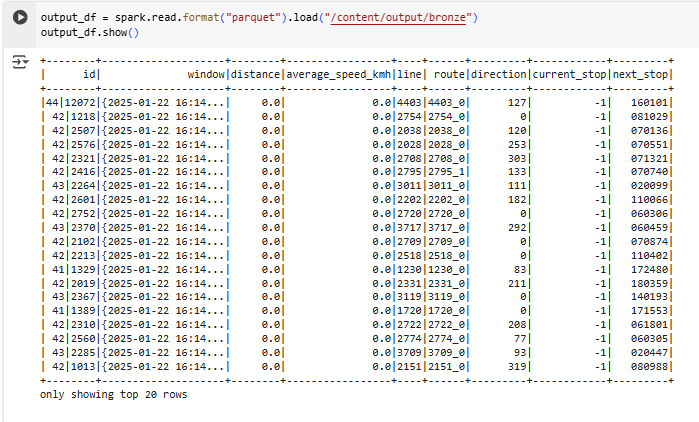

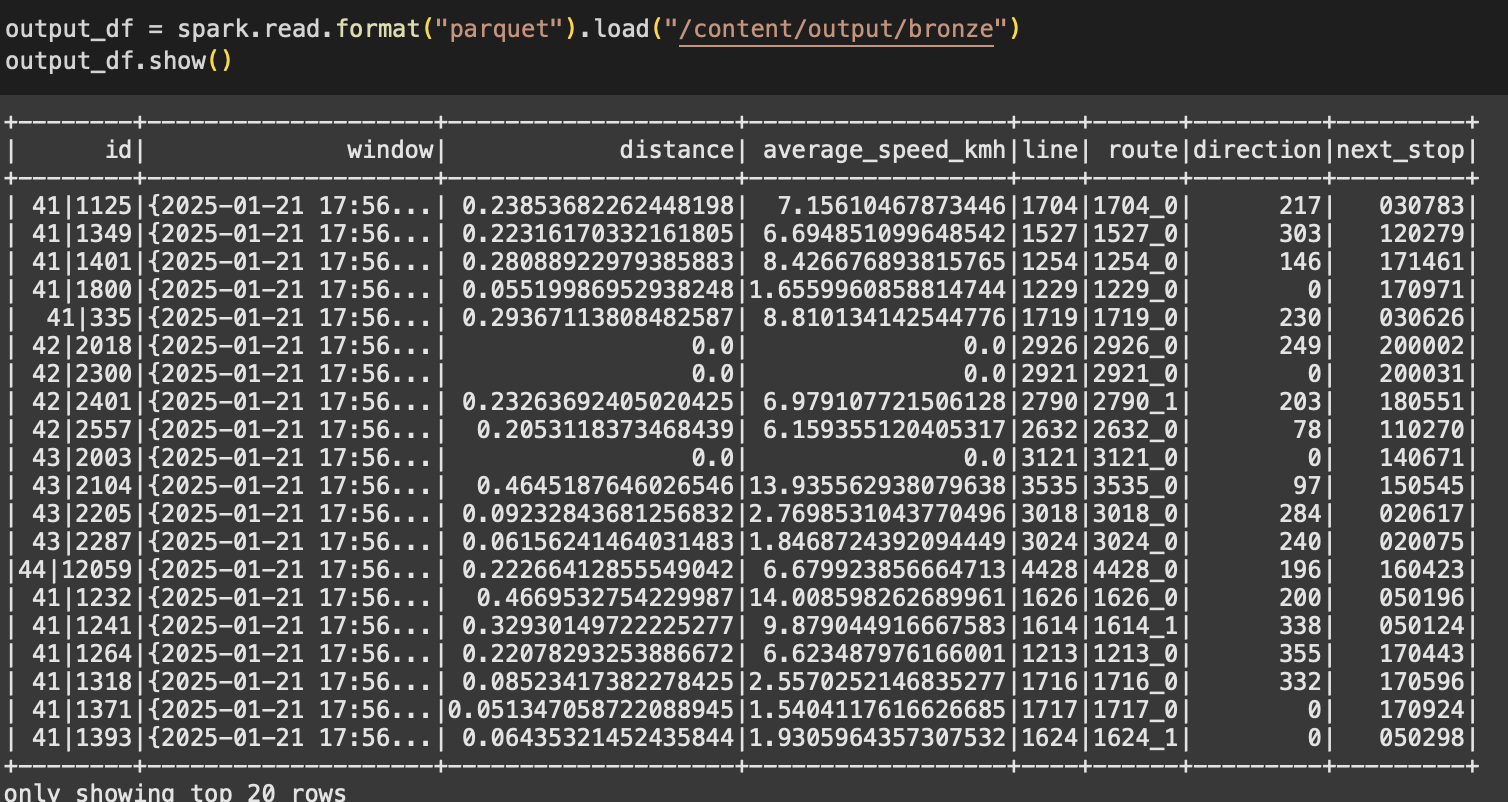